# Задание 3.2
- Решите задачу классификации для набора данных по варианту. При необходимости обоснуйте и примените обогащение данных.
Варианты заданий (определяются, как обычно: остатком от деления номера по списку на число вариантов):

Классификация млекопитающих - https://disk.yandex.ru/d/DrS7kTw3KWxjQg (9 классов млекопитающих)

In [1]:
# Импорты нужных нам библиотек и фреймворков
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import zipfile
import random
from shutil import copyfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Academic/ML/Lab09 - CNN/data_mammals")

In [4]:
import os

num_skipped = 0
for folder_name in ("dog", "cat", "wolf", "horse", "bear", "elephant", "lion", "goat", "tiger"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Удаляем испорченные и не поддерживаемые изображения
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
image_size = (150, 150)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 562 files belonging to 9 classes.
Using 450 files for training.
Found 562 files belonging to 9 classes.
Using 112 files for validation.


In [6]:
train_ds.take(1)
#  print(images)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

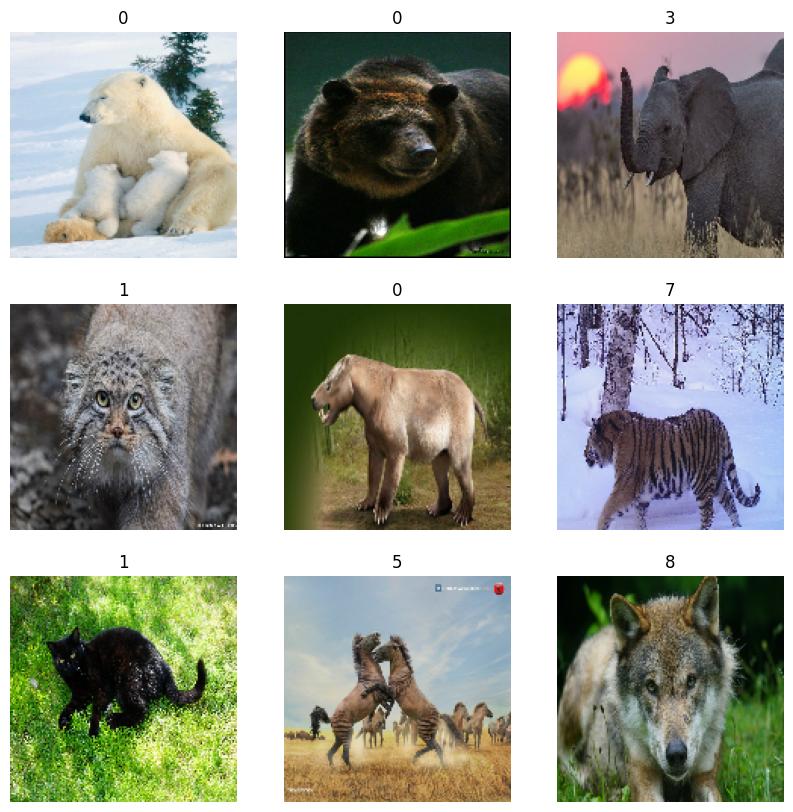

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        try:
            # Convert labels to integers
            label_value = int(labels[i])

            # Display image
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(label_value)
            plt.axis("off")
        except Exception as e:
            # Handle the exception (e.g., print an error message)
            print("Error displaying image:", e)

plt.show()

In [8]:
def learning_curves(history, epochs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    legend1 = ax1.legend(loc='best', shadow=True)

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend2 = ax2.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 128)               22429824  
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                        

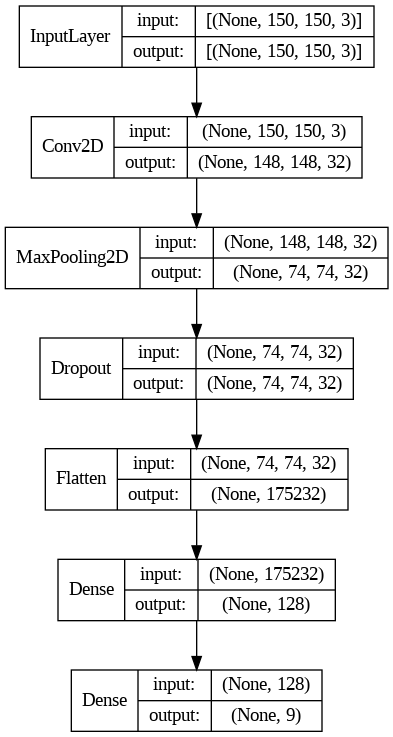

In [10]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 66s 2s/step - loss: 1956.7249 - accuracy: 0.1267 - val_loss: 72.8060 - val_accuracy: 0.2143
Epoch 2/10
29/29 [==============================] - 38s 1s/step - loss: 23.6795 - accuracy: 0.2756 - val_loss: 12.4824 - val_accuracy: 0.2232
Epoch 3/10
29/29 [==============================] - 43s 1s/step - loss: 3.4583 - accuracy: 0.5800 - val_loss: 9.4881 - val_accuracy: 0.2143
Epoch 4/10
29/29 [==============================] - 37s 1s/step - loss: 1.1618 - accuracy: 0.7622 - val_loss: 9.1214 - val_accuracy: 0.2411
Epoch 5/10
29/29 [==============================] - 38s 1s/step - loss: 0.4056 - accuracy: 0.9222 - val_loss: 9.5730 - val_accuracy: 0.2768
Epoch 6/10
29/29 [==============================] - 37s 1s/step - loss: 0.2794 - accuracy: 0.9689 - val_loss: 9.0613 - val_accuracy: 0.2679
Epoch 7/10
29/29 [==============================] - 36s 1s/step - loss: 0.1273 - accuracy: 0.9844 - val_loss: 9.4917 - val_accuracy: 0.2946
Epoch 8/10
29/

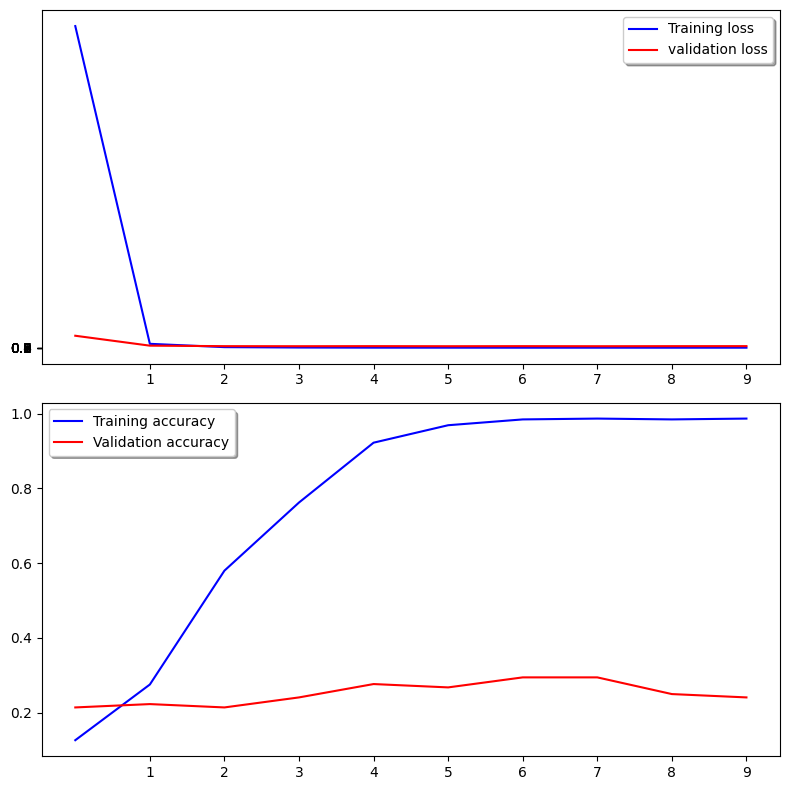

In [12]:
learning_curves(history, 10)

In [13]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

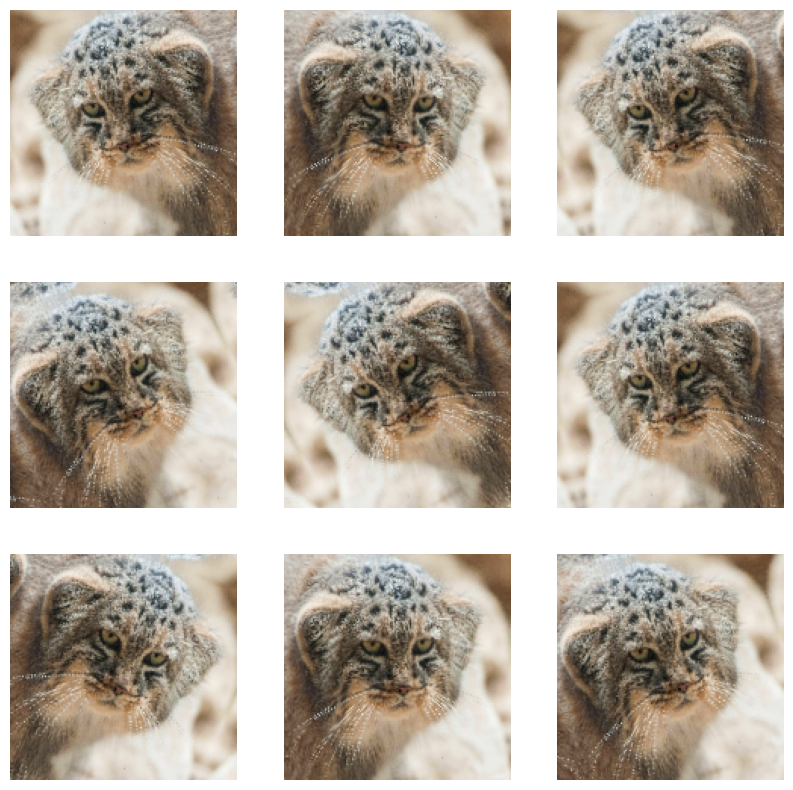

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.8,
    subset="validation",
    seed=24,
    image_size=image_size,
    batch_size=batch_size,
)

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 562 files belonging to 9 classes.
Using 449 files for validation.
29/29 [==============================] - 16s 451ms/step - loss: 1.6002 - accuracy: 0.8196
Test Loss: 1.6001828908920288
Test Accuracy: 0.8195990920066833
